# Repeat quasars

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
from astropy.table import Table, join, hstack, unique

 ### Query the data via `bossquery` from the bossdata package:
 #### http://bossdata.readthedocs.org/en/latest/scripts.html#bossquery

#### BOSS 

##### export BOSS_REDUX_VERSION=v5_7_0

`bossquery --full --what 'PLATE,MJD,FIBER,THING_ID,RUN,RERUN,CAMCOL,FIELD,ID,PLUG_RA,PLUG_DEC,SPECTROFLUX_1,SPECTROFLUX_2,SPECTROFLUX_3' --where 'CLASS="QSO" and ZWARNING=0 and Z_ERR>0 and RUN>0' --max-rows 400000 --save boss_qsos.dat`

#### DR13 (BOSS+SEQUELS)

##### export BOSS_REDUX_VERSION=v5_9_0

`bossquery --full --what 'PLATE,MJD,FIBER,THING_ID,RUN,RERUN,CAMCOL,FIELD,ID,PLUG_RA,PLUG_DEC,SPECTROFLUX_1,SPECTROFLUX_2,SPECTROFLUX_3' --where 'CLASS="QSO" and ZWARNING=0 and Z_ERR>0 and RUN>0' --max-rows 500000 --save dr13_qsos.dat`

#### eBOSS 

##### export BOSS_REDUX_VERSION=v5_9_1`

``bossquery --full --what 'PLATE,MJD,FIBER,THING_ID,RUN,RERUN,CAMCOL,FIELD,ID,PLUG_RA,PLUG_DEC,SPECTROFLUX_1,SPECTROFLUX_2,SPECTROFLUX_3' --where 'CLASS="QSO" and ZWARNING=0 and Z_ERR>0 and RUN>0 and EBOSS_TARGET1&4096>0' --max-rows 100000 --save eboss_qsos.dat``

In [6]:
boss = Table.read('boss_qsos.dat', format='ascii')
dr13 = Table.read('dr13_qsos.dat', format='ascii')
eboss = Table.read('eboss_qsos.dat', format='ascii')

In [5]:
print 'eBOSS returned %d quasars' %len(eboss)
print 'dr13 returned %d quasars' %len(dr13)
print 'BOSS returned %d quasars' %len(boss)

eBOSS returned 9851 quasars
dr13 returned 373115 quasars
BOSS returned 340202 quasars


### Match quasars

#### DR13/BOSS

In [111]:
dr13_boss_overlap = join(dr13, boss, keys=('RUN','RERUN','CAMCOL','FIELD', 'ID'), join_type='inner', table_names=('D','B'))
dr13_boss_overlap = dr13_boss_overlap.group_by(('PLATE_D','MJD_D','FIBER_D'))
dr13_boss_repeats = Table([dr13_boss_overlap['PLATE_D'],dr13_boss_overlap['MJD_D'],dr13_boss_overlap['FIBER_D'],dr13_boss_overlap['THING_ID_D'],dr13_boss_overlap['PLATE_B'],dr13_boss_overlap['MJD_B'],dr13_boss_overlap['FIBER_B'],dr13_boss_overlap['THING_ID_B']])

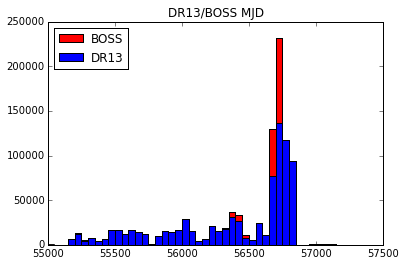

In [118]:
plt.title('DR13/BOSS MJD')
plt.hist(dr13_boss_repeats['MJD_B'], bins=50, color='r', label='BOSS', range=(55000, 57500))
plt.hist(dr13_boss_repeats['MJD_D'], bins=50, color='b', label='DR13', range=(55000, 57500))
plt.legend(loc='upper left');

#### eBOSS/BOSS

In [115]:
eboss_boss_overlap = join(eboss, boss, keys=('RUN','RERUN','CAMCOL','FIELD', 'ID'), join_type='inner', table_names=('E','B'))
eboss_boss_overlap = eboss_boss_overlap.group_by(('PLATE_E','MJD_E','FIBER_E'))
eboss_boss_repeats = Table([eboss_boss_overlap['PLATE_E'],eboss_boss_overlap['MJD_E'],eboss_boss_overlap['FIBER_E'],eboss_boss_overlap['THING_ID_E'],eboss_boss_overlap['PLATE_B'],eboss_boss_overlap['MJD_B'],eboss_boss_overlap['FIBER_B'],eboss_boss_overlap['THING_ID_B']])

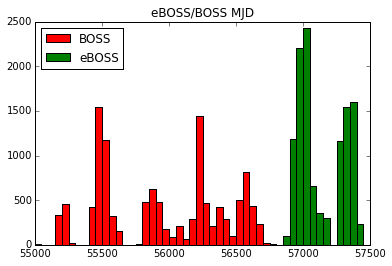

In [117]:
plt.title('eBOSS/BOSS MJD')
plt.hist(eboss_boss_repeats['MJD_B'], bins=50, color='r', label='BOSS', range=(55000, 57500))
plt.hist(eboss_boss_repeats['MJD_E'], bins=50, color='g', label='eBOSS', range=(55000, 57500))
plt.legend(loc='upper left');

#### eBOSS/DR13

In [7]:
eboss_dr13_overlap = join(eboss, dr13, keys=('RUN','RERUN','CAMCOL','FIELD', 'ID'), join_type='inner', table_names=('E','D'))
eboss_dr13_overlap = eboss_dr13_overlap.group_by(('PLATE_E','MJD_E','FIBER_E'))
eboss_dr13_repeats = Table([eboss_dr13_overlap['PLATE_E'], eboss_dr13_overlap['MJD_E'], eboss_dr13_overlap['FIBER_E'], eboss_dr13_overlap['THING_ID_E'], eboss_dr13_overlap['PLATE_D'], eboss_dr13_overlap['MJD_D'], eboss_dr13_overlap['FIBER_D'], eboss_dr13_overlap['THING_ID_D']])

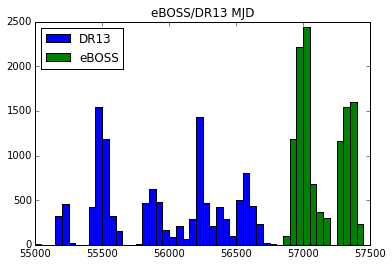

In [11]:
plt.title('eBOSS/DR13 MJD')
plt.hist(eboss_dr13_repeats['MJD_D'], bins=50, color='b', label='DR13', range=(55000, 57500))
plt.hist(eboss_dr13_repeats['MJD_E'], bins=50, color='g', label='eBOSS', range=(55000, 57500))
plt.legend(loc='upper left');

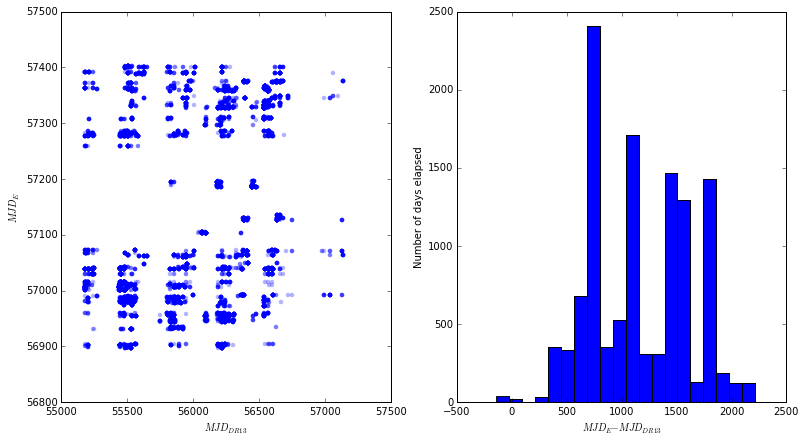

In [124]:
fig = plt.figure(figsize=(13,7))
plt.subplot(1,2,1)
plt.scatter(eboss_dr13_repeats['MJD_D'], eboss_dr13_repeats['MJD_E'], color='b',lw=0, alpha=0.3)
plt.xlabel('$MJD_{DR13}$')
plt.ylabel('$MJD_{E}$')
plt.subplot(1,2,2)
plt.hist(eboss_dr13_repeats['MJD_E']-eboss_dr13_repeats['MJD_D'], color='b', bins=20)
plt.xlabel('$MJD_{E}-MJD_{DR13}$')
plt.ylabel('Number of days elapsed');

In [142]:
def plot_statistics(x, y, num_bins):
    #1. trim data and eliminate negative flux values
    pos_vals = y > 0
    y = y[pos_vals]
    x = x[pos_vals]
    in_window = (y > np.percentile(y, 1))&(y < np.percentile(y, 99))
    y = y[in_window]
    x = x[in_window]
    y_mean = np.mean(y)
    #2. bin x
    percentile_step = 100./num_bins
    bin_edges = []
    for i in range(num_bins+1):
        bin_edges.append(np.percentile(x, percentile_step*(i)))
    bin_edges = np.array(bin_edges)
    #3. calculate moments
    zero_order = np.histogram(x, bins=bin_edges)[0]
    first_order = np.histogram(x, bins=bin_edges, weights=y)[0]
    second_order = np.histogram(x, bins=bin_edges, weights=y**2)[0]
    #4. calculate statistics
    mean = first_order/zero_order
    std_dev = np.sqrt(second_order/zero_order - mean**2)
    mean_err = std_dev/np.sqrt(zero_order)
    std_dev_err = std_dev/np.sqrt(2*(zero_order-1))
    #5. find mid-point of each bin
    x_axis = (bin_edges[:-1]+bin_edges[1:])/2.
    #6. plot stats
    plt.figure(figsize=(13,6))
    plt.subplot(1,2,1)
    plt.scatter(x_axis, mean, lw=0, color='r', alpha=0.5)
    plt.errorbar(x_axis, mean, ls='None', color='b', lw=1.5, yerr=mean_err)
    plt.xlabel('$\Delta MJD$')
    plt.ylabel('$Mean\,(m_{E} - m_{DR13})$', fontsize=16)
    plt.grid()
    plt.subplot(1,2,2)
    plt.scatter(x_axis, std_dev, lw=0, color='r', alpha=0.5)
    plt.errorbar(x_axis, std_dev, ls='None', color='g', lw=1.5, yerr=std_dev_err)
    plt.xlabel('$\Delta MJD$')
    plt.ylabel('$Std\,Dev\,(m_{E} - m_{DR13})$', fontsize=16)
    plt.grid()

##### g-band 

/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


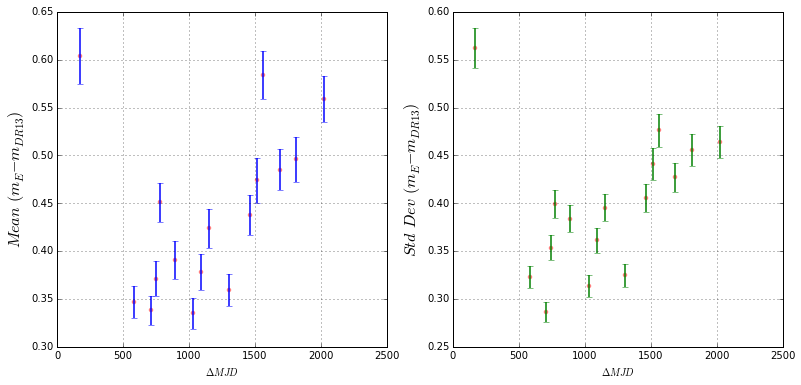

In [143]:
plot_statistics(eboss_dr13_overlap['MJD_E']-eboss_dr13_overlap['MJD_D'], 
                -2.5*np.log10(eboss_dr13_overlap['SPECTROFLUX_1_E']/eboss_dr13_overlap['SPECTROFLUX_1_D']), 16)

##### r-band

/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


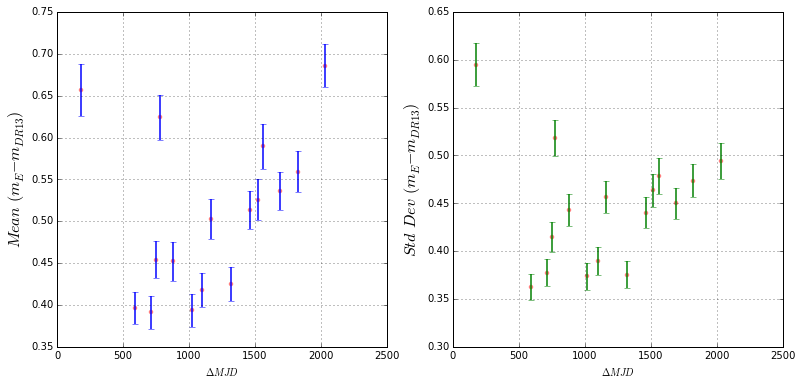

In [144]:
plot_statistics(eboss_dr13_overlap['MJD_E']-eboss_dr13_overlap['MJD_D'], 
                -2.5*np.log10(eboss_dr13_overlap['SPECTROFLUX_2_E']/eboss_dr13_overlap['SPECTROFLUX_2_D']), 16)

##### i-band

/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


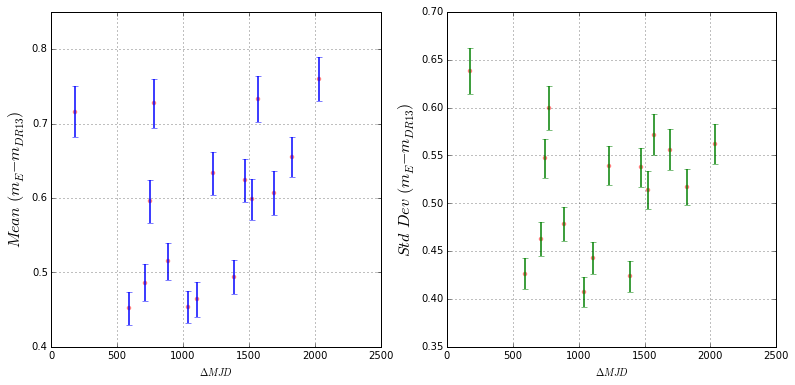

In [145]:
plot_statistics(eboss_dr13_overlap['MJD_E']-eboss_dr13_overlap['MJD_D'], 
                -2.5*np.log10(eboss_dr13_overlap['SPECTROFLUX_3_E']/eboss_dr13_overlap['SPECTROFLUX_3_D']), 16)